EE21S061 Arihant Jain Lab 6 for EE5175 course:

In [1]:
!pip install scipy

You should consider upgrading via the 'C:\Python310\python.exe -m pip install --upgrade pip' command.


In [2]:
from matplotlib import pyplot as plt
import random
%matplotlib inline


plt.rcParams['figure.figsize'] = [18, 10] 

Here i am using Function from previous lab for convolution and plotting the images in the stack

In [3]:
def plotter(x,y,data,offset):
    figure, axis = plt.subplots(x,y)
    num=0
    for i in range(x):
        for j in range(x):
            axis[i][j].imshow(data[:,:,num+offset],cmap="gray")
            title="Frame = " + str(num+offset)
            axis[i][j].set_title(title)
            num+=1

            
            
def convolution_2d(kernel,img):
    size=kernel.shape[0]
    pad=size//2
    res=np.zeros((img.shape[0],img.shape[1]))
    img=np.pad(img, (pad, pad), 'constant')
    #Zero padding the image to work around edge cases in the image
    for i in range(res.shape[0]):
        for j in range(res.shape[1]):
            #applying kernel on np array using slicing this allows us to reduce the length of code 
            # as well as use optimization done by numpy
            res[i][j] = (img[i:i+(2*pad)+1,j:j+(2*pad)+1]*kernel).sum()
    return res




First Order of buisness is to open the .mat file and extract the images in a way we can process them here i have loaded the stack.mat file and then placed the frames in a 3-d Numpy Array with z axis to traverse through the frames

In [4]:
from PIL import Image
from numpy import asarray
import cv2
import math
import numpy as np
from sympy import *
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

# load the image
import scipy.io
mat = scipy.io.loadmat('stack.mat')

delta_d=50.5

In [5]:
num_frames=[]
for temp in mat:
    if 'frame' in temp:
        num_frames.append(temp)
#Extracting the frames from the mat file
n=0
for i in range(len(num_frames)):
    if num_frames[i] == "numframes":
        n=mat[num_frames[i]][0][0]
        x,y=mat[num_frames[i+1]].shape
        print("X =",x," Y =",y," Num of frames ",n)
        frames=np.zeros((x, y, n))
    else:
        frames[:,:,i-1]=mat[num_frames[i]]
        #Storing the frame accross the z-axis of the numpy array


X = 115  Y = 115  Num of frames  100


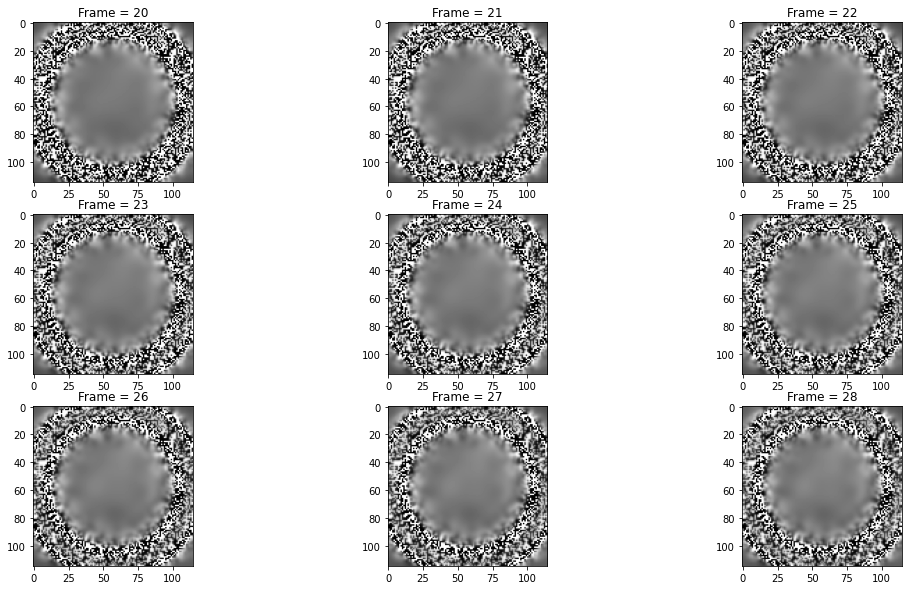

In [6]:
plotter(3,3,frames,20)

We can see using the plotter the images we have got in this assignment. This gives us an idea what to expect.

In [7]:
def modified_laplacian(frames):
    F_yy=np.array(([0, 1, 0],[0,-2,0],[0, 1, 0]), dtype="int")
    F_xx=np.array(([0, 0, 0],[1,-2,1],[0, 0, 0]), dtype="int")
    #Laplacian Kernel 
    f_x=f_y=frames_ml=np.zeros((x, y, n))
    for i in range(n):
        f_x[:,:,i]=convolution_2d(F_xx,frames[:,:,i])
        f_y[:,:,i]=convolution_2d(F_yy,frames[:,:,i])
        #Convolution with F_x and F_y kernels defined above
    for i in range(n):
        frames_ml[:,:,i]=abs(f_x[:,:,i])+abs(f_y[:,:,i])
        #Summing the 2 arrays together to get modified laplacian frames
    return frames_ml;

The above function has laplacian kernels defined in it for F_x and F_y which are then convolued with the frames indivdually this allows us to segment the code to hold intermediate data points.

In [8]:
def sum_modified_laplacian(frames,q):    
    if q==0:
        return frames
    k = 2*q+1
    x,y=frames[:,:,0].shape
    kernel=np.ones((k,k))
    #Intializing a simple kernel with all ones to sum over neighbours.
    frames_sml=np.zeros((x, y, n))
    #Forming a blank 3-d array to hold sml results
    for i in range(n):
        frames_sml[:,:,i]=convolution_2d(kernel,frames[:,:,i])
    return frames_sml

After getting the modified laplacian next order of buisness is to sum the two 3-d stacks we got for F_x and F_y kernels this function also takes in account q for using a summation kernel to sum neighbouring values to get more accurate results. 

In [9]:
def focus_img(frames_sml,frames):
    x,y=frames[:,:,0].shape
    res=np.zeros((x,y))
    for i in range(x):
        for j in range(y):
            temp=np.max(frames_sml[i,j,:])
            temp2=list(frames_sml[i,j,:])
            res[i][j]=frames[i,j,temp2.index(temp)]
    return res



Atlast we now have to find the max Focus operator value in the sum_modified_laplacian frames we got in the last cell this is then used to pick the pixel value from the original frames.

In [10]:
frames_ml=modified_laplacian(frames)

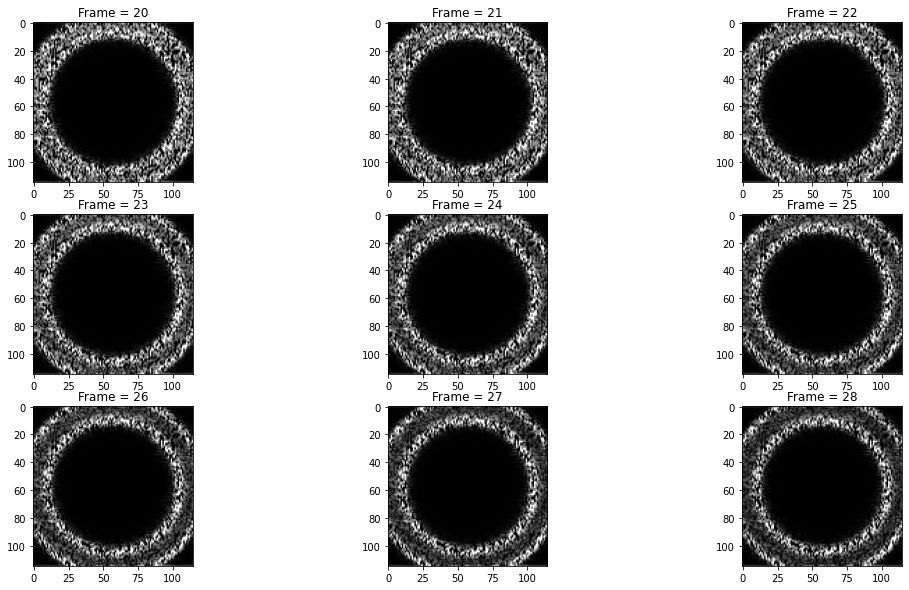

In [11]:
plotter(3,3,frames_ml,20)

In [12]:
q_s=[0,1,2]
frames_q_sml={}
for q in q_s:
    frames_q_sml[q]=sum_modified_laplacian(frames_ml,q)


# Q=0

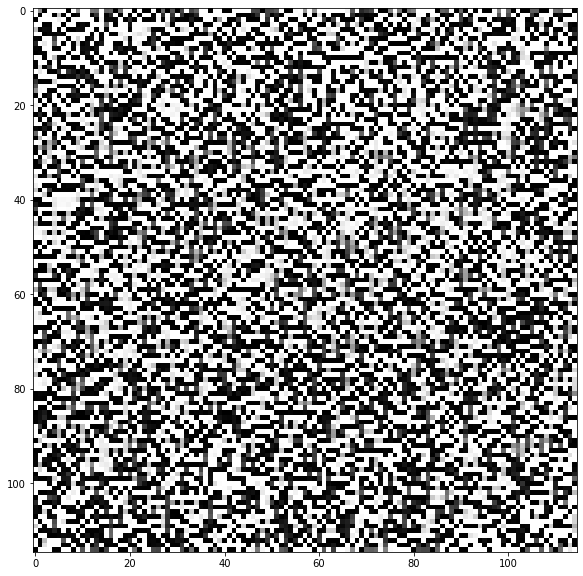

In [13]:
plt.imshow(focus_img(frames_q_sml[0],frames),cmap="gray")

here we can see the results of the focus img function. The images looks sharp but there are some artifacts near the center we can try for different value of q to sum over neighbouring values to find a better result

# Q=1

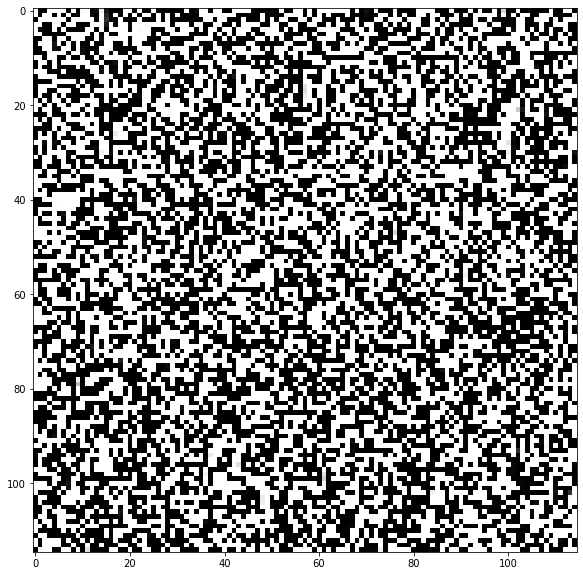

In [14]:
plt.imshow(focus_img(frames_q_sml[1],frames),cmap="gray")

The results seems to similar here as well lets try for q=2

# Q=2

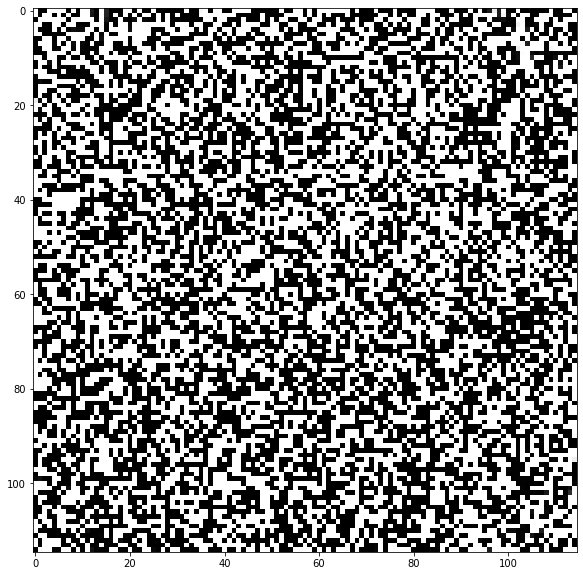

In [15]:
plt.imshow(focus_img(frames_q_sml[2],frames),cmap="gray")

The artifacts in the middles seems to be fading away but still the image still looks as sharp in q=0 as its in q=2

In [16]:
def depth_img(frames):
    x,y,z=frames.shape
    X, Y = np.meshgrid(np.arange(x)+1, np.arange(y)+1)
    Z=np.argmax(frames, axis=2)*delta_d
    return X,Y,Z

Now that we know which pixel are in focus at which frames we can form a 3-d shape from the image data given delta_d=50.50

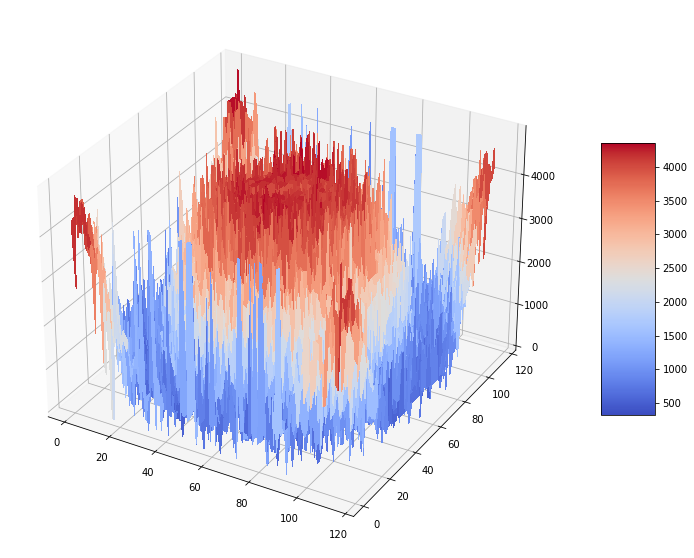

In [17]:
X,Y,Z=depth_img(frames_q_sml[0])

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

Here we can see how the image although looks really sharp the shape seems to be a bit noisy lets look at same results for q=1,2

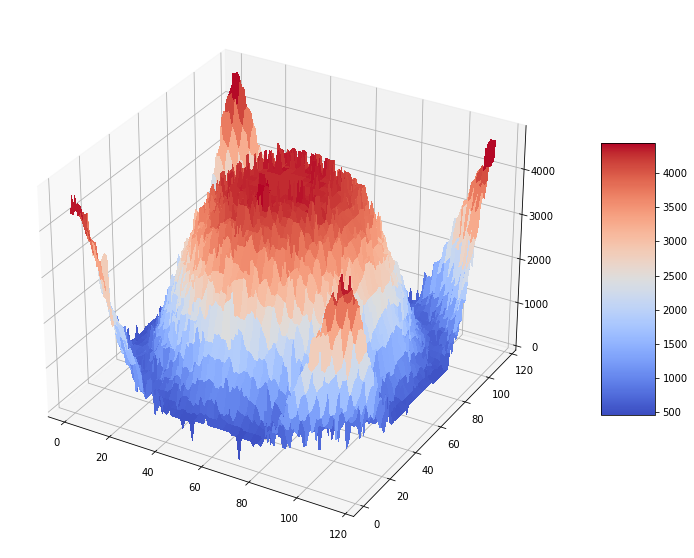

In [18]:
X,Y,Z=depth_img(frames_q_sml[1])

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

The shape data we got at q=1 seems a bit smooth this is is because we assume a certain smoothness in the real world which allows us to sum over neighbouring values

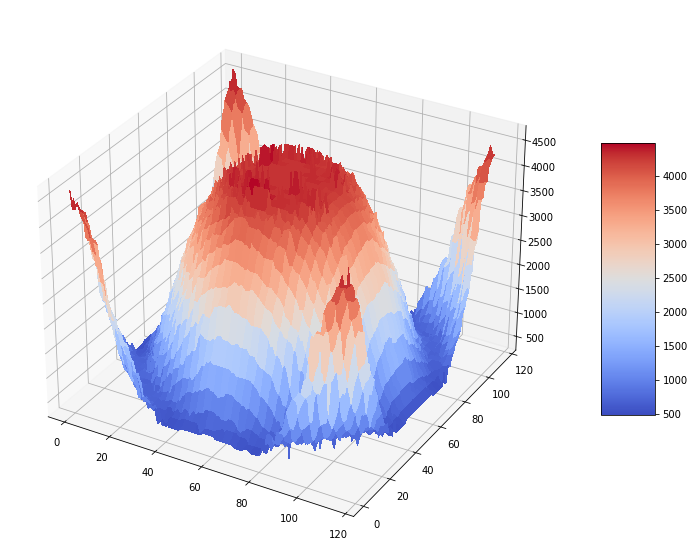

In [19]:
X,Y,Z=depth_img(frames_q_sml[2])

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

At Q=2 the shape is much smoother and better this gives us a good look at the performance of sum modified laplacian and how it varies over different sum kernels.